## 3A - L2 Perspective Imaging

In [3]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

### Perspective Projection

#### Projection of a point

Below we'll model an imaging system and compute and plot the projection of a 3D world coordinate in the 2D image plane

In [4]:
def compute_projection(f, point):
    '''
    Computes the projection of a point on an image plane at a 
    distance f from the centre of projection. 
    Assumes the centre of projection is located at the origin and follows a 
    right handed axial system.
    
    Parameters
    -----------
    f - focal length, float
        distnace of the image plane from COP
    point - np.ndarray, shape -  1 x 4
            point in the 3D space
            
    Returns
    --------
    projected_point - np.ndarray, shape - 1 x 3
        the projected point on the image plane
    '''
    # convert into a homogeneous coordinate
    if point.size == 3:
        point = np.hstack((point, np.ones(1)))
        
    point = np.expand_dims(point, axis=1)
        
    # create the projection matrix
    H = np.zeros((3, 4))
    np.fill_diagonal(H, 1)
    H[2, 2] = 1/f
    
    # compute projection
    h = np.matmul(H, point)
    
    # this gives us a homogeneous coordinate
    # to convert it back to a euclidean coordinate, we divide by the last coordinate
    h = h.flatten()
    h[0] = h[0]/h[2]
    h[1] = h[1]/h[2]
    
    u = np.ones(2)
    u[0], u[1] = h[0], h[1]
    
    # now, we get the projection of the point in euclidean space wrt image
    # but we want the coordinate wrt world scene. hence we add z=f to the last
    v = np.hstack((u, np.ones(1) * f))
    
    return v

In [5]:
make_line = lambda u, v: np.vstack((u, v)).T

In [6]:
# define parameters
d = 3 # d is the distance between cop and image plane and is assumed to be +ve
f = -d # focal length
cop = np.array([0, 0, 0]) # center of projection
p = np.array([7, 9, -8]) # world coordinate

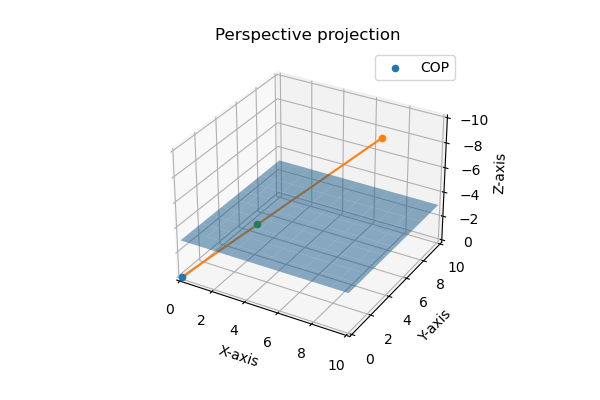

In [7]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(0, 10), ylim=(0, 10), zlim=(0, -10))

# plot centre of projection at the origin
ax.scatter(*cop, label="COP")

# plot the image plane
xx, yy = np.meshgrid(range(0, 11), range(0, 11)) 
z = np.ones(shape=(xx.shape))  * f

ax.plot_surface(xx, yy, z, alpha=0.5)

# plot the world coordinate
ax.scatter(*p)

# plot the ray from the world coordinate to the COP
ray = make_line(cop, p)
ax.plot(*ray)

# compute the projection of the world coordinate on the image plane
v = compute_projection(f, p)

# plot the projection point
ax.scatter(*v)

# set labels
ax.set_title("Perspective projection")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

#### Projecting a line

consider a line $l = p + \lambda t$ where p is any point on the line and t is the direction. To compute the projection of this line, we'll find the projection of p and t and plot a line between the projections, because remember lines always project to lines

In [8]:
# define parameters
p = np.array([8, 9, -8]) 
q = np.array([2, 8, -7]) 

s = 3 # scaling factor

In [45]:
def extend_line(p, q, f, x_min=0, x_max=10):
    '''
    given two points p & t, extend the line between them to min and max of x.
    
    Idea
    -----
    The equation of a line joining two points is (x-x1)/(x2-x1) = (y-y1)/(y2-y1) = (z-z1)/(z2-z1)
    where p =(x1, y1, z1) and t = (x2, y2, z2).
    we plug in x = _min and x = _max and compute corresponding y and z.
    
    returns
    --------
    (_min, y, z), (_max, y`, z`)
    '''
    # compute x2 - x1, y2 - y1, and z2- z1
    diff = q - p
    
    # compute (x_min - x1)/(x2 - x1)
    s_min = (x_min - p[0]) / diff[0]
    
    # compute y
    y = s_min * diff[1] + p[1]
    
    # compute z
    z = s_min * diff[2] + p[2] if diff[2] != 0 else f
    
    # repeat the same for x_max
    s_max = (x_max - p[0]) / diff[0]
    y_ = s_max * diff[1] + p[1]    
    z_ = s_max * diff[2] + p[2] if diff[2] != 0 else f
    
    return np.array([x_min, y, z]), np.array([x_max, y_, z_]) 

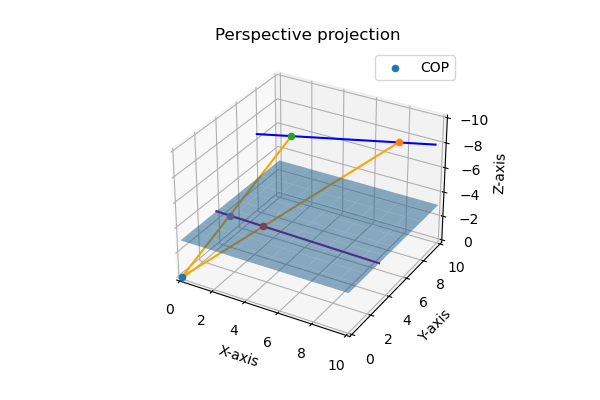

In [46]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(0, 10), ylim=(0, 10), zlim=(0, -10))

# plot centre of projection at the origin
ax.scatter(*cop, label="COP")

# plot the image plane
xx, yy = np.meshgrid(range(0, 11), range(0, 11))
z = np.ones(shape=(xx.shape))  * f

ax.plot_surface(xx, yy, z, alpha=0.5)

# plot p and t
ax.scatter(*p)
ax.scatter(*q)

# extend the line between p & t
p_extd, q_extd = extend_line(p, q, f)

# plot the extended line between p & t
ax.plot(*make_line(p_extd, q_extd), color="blue")

# plot the ray from p & t to the COP
ax.plot(*make_line(cop, p), color="orange")
ax.plot(*make_line(cop, q), color="orange")

# compute and plot the projection of p & t
u = compute_projection(f, p)
v = compute_projection(f, q)

# plot u and v
ax.scatter(*u)
ax.scatter(*v)

# extend the line between u & v
u_extd, v_extd = extend_line(u, v, f)

# plot the line between p & t
ax.plot(*make_line(u_extd, v_extd), color="purple")

# set labels
ax.set_title("Perspective projection")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

#### Project multiple parallel lines

Project multiple parallel lines and see where they intersect in the image plane

**Idea:** We know that if p, q are two points that form a line, then $t = q - p$ is the direction vector of that line. So, we can compute lines that are parallel to $\overrightarrow{pq}$ using the idea that parallel lines have the same $t$. So any line parallel to $\overrightarrow{pq}$ has the form $u + \lambda t$ where $t = q - p$

In [47]:
def compute_parallel_lines(u, p, q, s):
    '''
    Computes line parallel to pq and containing the point u using the
    above mentioned idea
    
    Parameters
    ------------
    p, q - np.ndarray, shape - (,3)
        two points on the line
    u - np.ndarray, shape - (,3)
        point on the parallel line 
    s - float
        the scale factor
        
    Returns
    ---------
    v - np.ndarray, shape - (,3)
        point v such that uv is parallel to pq
    '''
    t = q - p
    v = u + s * t
    
    return v
    

In [48]:
# define parameters
p = np.array([8, 9, -8]) 
q = np.array([2, 8, -7]) 
u = np.array([6, 9, -9]) 
a = np.array([6, 7, -8])

s = 0.6 # scaling factor

In [49]:
# compute parallel lines
v = compute_parallel_lines(u, p, q, s)
b = compute_parallel_lines(a, p, q, s)

In [55]:
lim = 15

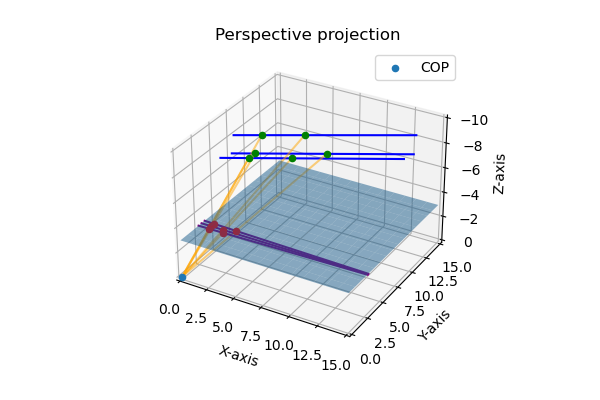

In [59]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(0, lim), ylim=(0, lim), zlim=(0, -10))

# plot centre of projection at the origin
ax.scatter(*cop, label="COP")

# plot the image plane
xx, yy = np.meshgrid(range(0, lim + 1), range(0, lim + 1))
z = np.ones(shape=(xx.shape))  * f

ax.plot_surface(xx, yy, z, alpha=0.5)

# plot all the points
ax.scatter(*p, color="green")
ax.scatter(*q, color="green")
ax.scatter(*u, color="green")
ax.scatter(*v, color="green")
ax.scatter(*a, color="green")
ax.scatter(*b, color="green")

# extend the lines pq, uv, ab
p_extd, q_extd = extend_line(p, q, f, x_min=0, x_max=lim)
u_extd, v_extd = extend_line(u, v, f, x_min=0, x_max=lim)
a_extd, b_extd = extend_line(a, b, f, x_min=0, x_max=lim)

# plot the lines
ax.plot(*make_line(p_extd, q_extd), color="blue")
ax.plot(*make_line(u_extd, v_extd), color="blue")
ax.plot(*make_line(a_extd, b_extd), color="blue")

# plot rays from cop
ax.plot(*make_line(cop, p), color="orange", alpha=0.5)
ax.plot(*make_line(cop, q), color="orange", alpha=0.5)
ax.plot(*make_line(cop, u), color="orange", alpha=0.5)
ax.plot(*make_line(cop, v), color="orange", alpha=0.5)
ax.plot(*make_line(cop, a), color="orange", alpha=0.5)
ax.plot(*make_line(cop, b), color="orange", alpha=0.5)

# compute and plot the projection points
p_ = compute_projection(f, p)
q_ = compute_projection(f, q)
u_ = compute_projection(f, u)
v_ = compute_projection(f, v)
a_ = compute_projection(f, a)
b_ = compute_projection(f, b)

ax.scatter(*p_, color="red")
ax.scatter(*q_, color="red")
ax.scatter(*u_, color="red")
ax.scatter(*v_, color="red")
ax.scatter(*a_, color="red")
ax.scatter(*b_, color="red")

# plot the lines between the projected points
p_extd, q_extd = extend_line(p_, q_, f, x_min=0, x_max=lim)
u_extd, v_extd = extend_line(u_, v_, f, x_min=0, x_max=lim)
a_extd, b_extd = extend_line(a_, b_, f, x_min=0, x_max=lim)

ax.plot(*make_line(p_extd, q_extd), color="purple")
ax.plot(*make_line(u_extd, v_extd), color="purple")
ax.plot(*make_line(a_extd, b_extd), color="purple")

# set labels
ax.set_title("Perspective projection")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

**Observations:**
1. Parallel lines in the world space are intersecting in the image plane
2. Parallel lines along the same direction in the world space intersect at a single point in the image plane